In [1]:
# DRIVE CONNECTION
from google.colab import drive
import os #phyton “operating system” kütüphanesi

print("Connecting to Google Drive...")
drive.mount('/content/drive')
print("✅Connection Successful!")

#DOSYA KONTROLÜ
zip_yolu = "/content/drive/MyDrive/Sound Source.zip" #dosyanın gerçekten orda olup olmadığını kontrol ediyo
if os.path.exists(zip_yolu):
    print(f"✅Zip file found: {zip_yolu}")
else:
    print("ERROR: File not found!")

Connecting to Google Drive...
Mounted at /content/drive
✅Connection Successful!
✅Zip file found: /content/drive/MyDrive/Sound Source.zip


In [2]:
# LIBRARIES AND BASIC SETTINGS
import os
import zipfile
import numpy as np
import librosa #ÇOK ÖNEMLİ Ses işleme kütüphanesi
#Sesi yükleyip, saniyelerini ayarlayıp ve Mel-Spektrogram resmine çevirir
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt #Grafik çizmek için
import seaborn as sns #Grafik çizmek için)

# "RIGOR" için rastgeleliği sabitliyoruz(with seed)
torch.manual_seed(42)
np.random.seed(42)

# Sabit Değerler (Config)
ZIP_YOLU = "/content/drive/MyDrive/Sound Source.zip"
CIKARTMA_KLASORU = "./veri_seti"
HEDEF_SURE = 3.0 # Her ses 3 saniye olacak
SR = 22050 #sample rate
HEDEF_UZUNLUK = int(HEDEF_SURE * SR) #input size
BATCH_SIZE = 16 #mini batch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Setup complete. Operating device:{DEVICE}")

Setup complete. Operating device:cuda


In [3]:
# DATA PRE-PROCESSING AND LOADING

# 1. Zip Dosyasını Açma
if not os.path.exists(CIKARTMA_KLASORU):
    print("📦 Zip file is opening... Please wait")
    with zipfile.ZipFile(ZIP_YOLU, 'r') as zip_ref: #r=sayesinde dosya okuma modunda açılır ve alınabilcek hata karşısında direkt dosyayı kapatır
        zip_ref.extractall(CIKARTMA_KLASORU) #extracall metodu Zip'in içindeki binlerce ses dosyasını alır ve bizim belirlediğimiz CIKARTMA_KLASORU içine tek tek yerleştirir. Asıl ağır işi yapan satır budur.
    print("✅ The zip file has been extracted.")
else:
    print("The files have already been moved to the folder.")

#Bilgisayar ses dosyasını (wav) doğrudan anlayamaz.
#Bu fonksiyon, sesi önce sayılara, sonra da görüntüye (Mel-Spektrogram) çevirir.
#CNN aslında sesi değil, bu oluşturduğumuz resmi analiz eder.
     # 2. Ses İşleme Fonksiyonu (Mel-Spectrogram)
def ses_isleme(dosya_yolu):
    y, sr = librosa.load(dosya_yolu, sr=SR)

    # Süreyi 3 saniyeye sabitle (Eksikse doldur, fazlaysa kırp)
    if len(y) > HEDEF_UZUNLUK:
        y = y[:HEDEF_UZUNLUK]
    else:
        eksik_kisim = HEDEF_UZUNLUK - len(y)
        y = np.pad(y, (0, eksik_kisim), mode='constant')

    #Mel-Spektrogram sesin hem Zaman hem de Frekans bilgisini birleştirir.
    #Ayrıca insan kulağının algısına (Mel Scale) göre ayarlandığı için duygu değişimlerini (tonlama, vurgu) yakalamakta en başarılı yöntem budur.
    #(Not: Bu bilgi literatür taraması kısmında okuduğumuz makalelere dayanıyor.)
    # Sesi resme çevir
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    return librosa.power_to_db(melspec, ref=np.max)

# 3. Klasörleri Gezip Veriyi Okuma
print("🏭 Data processing...")
X_veri = []
y_etiket = []
duygular = {"Angry": 0, "Calm": 1, "Happy": 2, "Sad": 3}
sinif_isimleri = ["Angry", "Calm", "Happy", "Sad"]

for root, dirs, files in os.walk(CIKARTMA_KLASORU):
    for file in files:
        if file.endswith(".wav") and not file.startswith("._"): # Gizli dosyaları atla file cleaning
            dosya_yolu = os.path.join(root, file)
            klasor_adi = os.path.basename(os.path.dirname(dosya_yolu))

            if klasor_adi in duygular:
                try:
                    veri = ses_isleme(dosya_yolu)
                    X_veri.append(veri)
                    y_etiket.append(duygular[klasor_adi])
                except Exception as e:
                    print(f"Hata: {file} okunamadı.")

# Listeyi Numpy formatına çevir
X = np.array(X_veri)[:, np.newaxis, :, :] # Boyut: (N, 1, 64, 130) renki resim olsa rgb(3boyutlu) olucaktı ama bizim sesimiz siyah beyaz olduğu için 1katmanlı
y = np.array(y_etiket)

#Soru: "Kodundaki [:, np.newaxis, :, :] kısmı ne işe yarıyor? Neden buna ihtiyaç duydun?"
#PyTorch'taki Conv2d (Konvolüsyon) katmanları giriş verisini standart bir formatta bekler:
#(Batch Size, Channel, Height, Width).
#Bizim Mel-Spektrogramlarımız gri tonlamalı (Grayscale) olduğu için renk kanalı boyutu eksikti.
#np.newaxis ile o eksik olan 'Channel=1' boyutunu veriye ekledim.
#Bunu yapmasaydım model boyut uyuşmazlığı hatası (Shape Mismatch Error) verirdi."

print(f"📊 Number of Total Processed Data: {len(X)}")

📦 Zip file is opening... Please wait
✅ The zip file has been extracted.
🏭 Data processing...
📊 Number of Total Processed Data: 1735


In [4]:
#SPLIT THE DATA SET
# Adım 1: %80 Eğitim (Train), %20 Geçici
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify sayesinde her duygu her parçaya eşit dağılır

# Adım 2: Geçici kısmı ikiye böl -> %10 Validation, %10 Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verileri PyTorch formatına (DataLoader) çevir
train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train)), batch_size=BATCH_SIZE, shuffle=True) #shuffle sayesinde overfittingi engelledik
val_loader = DataLoader(TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val)), batch_size=BATCH_SIZE) #model daha iyi öğrensin diye mini batchlere böldük
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test)), batch_size=BATCH_SIZE)

print(f"✅ Data Split Complete: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")
#literatürde küçük ve orta ölçekli veri setleri (1.000 - 10.000 arası) için en kabul gören standart 80/10/10 ayrımıdır.

✅ Data Split Complete: Train=1388, Validation=173, Test=174


In [5]:
# ADVANCED CNN ARCHITECTURE

class GelismisCNN(nn.Module):
    def __init__(self):
        super(GelismisCNN, self).__init__()


        # Model 1'den Farkı: Tek Conv yerine Çift Conv kullanıyoruz.
        # Neden? Sesi hemen küçültmeden önce daha detaylı incelemek için.
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Batch Norm: Eğitimi hızlandırır ve dengeler
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2, 2) # Boyut: (64, 130) -> (32, 65)
        )

        # --- BLOK 2: Orta Seviye (Ritim, Ton) ---
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), #kanal sayısını arttırıp daha detaylı incelemeyi başlatıyoruz
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2) # Boyut: (32, 65) -> (16, 32)
        )

        # --- BLOK 3: Soyut Özellikler (Duygu Nüansları) ---
        # Model 1 burada bitiyordu. Model 2 devam ediyor!
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2, 2) # Boyut: (16, 32) -> (8, 16)
        )

        # --- BLOK 4: En Derin Analiz (Calm vs Sad Ayrımı) ---
        # Bu blok tamamen YENİ. Modelin soyutlama yeteneğini artırır.
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Boyut: (8, 16) -> (4, 8)
        )

        # --- SINIFLANDIRICI (Classifier Head) ---
        # Matematik: Son çıkan harita 256 kanal, 4 yükseklik, 8 genişlik
        self.flatten_size = 256 * 4 * 8

        self.classifier = nn.Sequential(
            nn.Flatten(),

            # Katman 1: Geniş Beyin
            nn.Linear(self.flatten_size, 512),
            nn.BatchNorm1d(512), # Dense layer için de normalizasyon
            nn.ReLU(),
            nn.Dropout(0.5), # %50 Unutma (Model 1'de %30 idi. Ezberi önlemek için artırdık)

            # Katman 2: Daraltma
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Çıkış: 4 Duygu
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x

# Modeli Oluştur ve GPU'ya Gönder
model = GelismisCNN().to(DEVICE)

# --- OPTIMIZER FARKI (ÇOK ÖNEMLİ) ---
# Model 1: Sadece Learning Rate vardı.
# Model 2: 'weight_decay=1e-4' ekledik. (L2 Regularization)
# Bu, modelin ağırlıklarının aşırı büyümesini matematiksel olarak engeller (Overfitting Kalkanı).
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print("🚀 Model 2 (Advanced VGG-Style) başarıyla oluşturuldu!")
print(f"   Model Parametre Sayısı: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

🚀 Model 2 (Advanced VGG-Style) başarıyla oluşturuldu!
   Model Parametre Sayısı: 4,845,284


In [6]:
# --- HÜCRE 6: MODEL 2 EĞİTİMİ (TRAINING) ---

print("🚀 Model 2 (VGG-Style) eğitimi başlıyor...")

# İstatistikleri tutacağımız listeler
train_losses = []
val_accuracies = []
best_acc = 0.0
EPOCH_SAYISI = 30 # Model 1'den (20) daha uzun tutuyoruz çünkü model daha derin.

for epoch in range(EPOCH_SAYISI):
    # --- 1. EĞİTİM MODU (TRAIN) ---
    model.train() # DİKKAT: Batch Norm ve Dropout'u aktif eder. Çok önemli!
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) # GPU'ya taşı

        optimizer.zero_grad() # Eski türevleri temizle
        outputs = model(inputs) # Tahmin yap
        loss = criterion(outputs, labels) # Hatayı ölç
        loss.backward() # Geriye yayılım (Backprop)
        optimizer.step() # Ağırlıkları güncelle

        running_loss += loss.item()

    # --- 2. SINAV MODU (VALIDATION) ---
    model.eval() # DİKKAT: Batch Norm ve Dropout'u dondurur. Sadece ölçüm yapar.
    correct = 0
    total = 0

    with torch.no_grad(): # Hafızayı yorma (Türev alma)
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # --- 3. İSTATİSTİKLER VE KAYIT ---
    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total

    train_losses.append(avg_loss)
    val_accuracies.append(acc)

    # En iyi skoru yakalarsan kaydet ("Save Point")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model2.pth') # Model 2 olarak kaydediyoruz!
        print(f"Epoch {epoch+1}/{EPOCH_SAYISI}: Loss={avg_loss:.4f} | Accuracy=%{acc:.2f} (⭐ Yeni Rekor!)")
    else:
        print(f"Epoch {epoch+1}/{EPOCH_SAYISI}: Loss={avg_loss:.4f} | Accuracy=%{acc:.2f}")

print(f"🏁 Eğitim Tamamlandı! En Yüksek Başarı (Best Val Acc): %{best_acc:.2f}")

🚀 Model 2 (VGG-Style) eğitimi başlıyor...
Epoch 1/30: Loss=1.2124 | Accuracy=%35.26 (⭐ Yeni Rekor!)
Epoch 2/30: Loss=0.9294 | Accuracy=%46.82 (⭐ Yeni Rekor!)
Epoch 3/30: Loss=0.7445 | Accuracy=%52.02 (⭐ Yeni Rekor!)
Epoch 4/30: Loss=0.5808 | Accuracy=%47.40
Epoch 5/30: Loss=0.5606 | Accuracy=%76.30 (⭐ Yeni Rekor!)
Epoch 6/30: Loss=0.4418 | Accuracy=%76.88 (⭐ Yeni Rekor!)
Epoch 7/30: Loss=0.3667 | Accuracy=%79.19 (⭐ Yeni Rekor!)
Epoch 8/30: Loss=0.3488 | Accuracy=%69.36
Epoch 9/30: Loss=0.2995 | Accuracy=%69.36
Epoch 10/30: Loss=0.2569 | Accuracy=%84.39 (⭐ Yeni Rekor!)
Epoch 11/30: Loss=0.2395 | Accuracy=%61.27
Epoch 12/30: Loss=0.2323 | Accuracy=%83.24
Epoch 13/30: Loss=0.1671 | Accuracy=%89.02 (⭐ Yeni Rekor!)
Epoch 14/30: Loss=0.1891 | Accuracy=%84.39
Epoch 15/30: Loss=0.1529 | Accuracy=%77.46
Epoch 16/30: Loss=0.1205 | Accuracy=%90.75 (⭐ Yeni Rekor!)
Epoch 17/30: Loss=0.0993 | Accuracy=%82.08
Epoch 18/30: Loss=0.1173 | Accuracy=%88.44
Epoch 19/30: Loss=0.1110 | Accuracy=%86.71
Epoch 

🕵️‍♂️ Model 2 (Advanced) Final Test Başlıyor...

=== MODEL 2: DETAYLI SINIFLANDIRMA RAPORU ===
              precision    recall  f1-score   support

       Angry       0.94      0.90      0.92        49
        Calm       0.91      0.78      0.84        41
       Happy       0.91      0.91      0.91        35
         Sad       0.81      0.94      0.87        49

    accuracy                           0.89       174
   macro avg       0.89      0.88      0.89       174
weighted avg       0.89      0.89      0.88       174



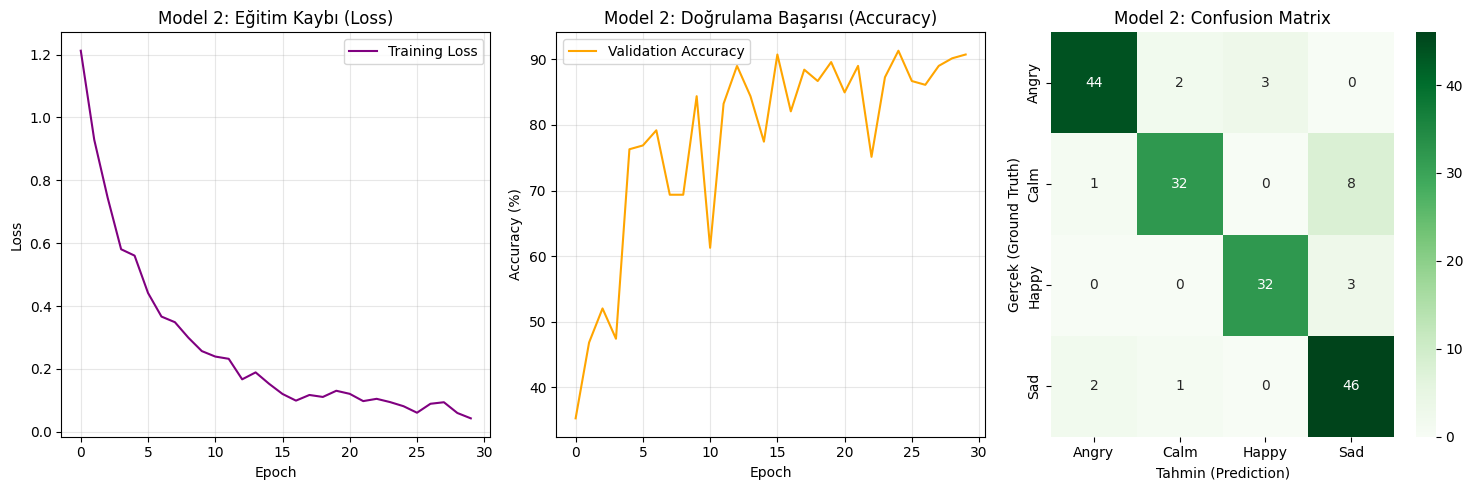

In [7]:
# --- HÜCRE 7: MODEL 2 TEST SONUÇLARI VE ANALİZ ---

print("🕵️‍♂️ Model 2 (Advanced) Final Test Başlıyor...")

# 1. En İyi Modeli Geri Yükle (Checkpoint Loading)
# Eğitim bittiğinde model belki son epochta yorulmuş olabilir.
# Biz en yüksek skoru aldığı "best_model2.pth" dosyasını yüklüyoruz.
model.load_state_dict(torch.load('best_model2.pth'))
model.eval() # Sınav modu (Dropout ve Batch Norm dondurulur)

y_gercek = []
y_tahmin = []

# 2. Test Seti Üzerinde Tahmin (Inference)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # GPU'dan CPU'ya çekip listeye ekle
        y_gercek.extend(labels.cpu().numpy())
        y_tahmin.extend(predicted.cpu().numpy())

# 3. Metrik Raporu (Classification Report)
print("\n=== MODEL 2: DETAYLI SINIFLANDIRMA RAPORU ===")
print(classification_report(y_gercek, y_tahmin, target_names=sinif_isimleri))

# 4. Görselleştirme (Visualization)
plt.figure(figsize=(15, 5))

# A) Loss Grafiği (Eğitim Kaybı)
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='purple')
plt.title('Model 2: Eğitim Kaybı (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# B) Accuracy Grafiği (Başarı)
plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Model 2: Doğrulama Başarısı (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# C) Confusion Matrix (Hata Matrisi)
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_gercek, y_tahmin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=sinif_isimleri, yticklabels=sinif_isimleri)
plt.title('Model 2: Confusion Matrix')
plt.ylabel('Gerçek (Ground Truth)')
plt.xlabel('Tahmin (Prediction)')

plt.tight_layout()
plt.show()